### Test M2_v2 with simulations
### E Flynn
### 1/17/2018

I updated model2 to include a variance-covariance matrix in the non-sex-specific component.
This is code that I used to test the updated model 2 and to examine some of the initial results.

In summary:

Simulations: 
- (1) It appears that if the values of the sex-specific variances are similar to the values in the variance-covariance matrix, there is some sort of identifiability issue. The estimates of the sex-specific variances get blown up, and we do not retrieve the true values for the parameters, specifically the estimates for the sex-specific components are smaller in addition to having blown up variance estimates (ex. 6-7 instead of 0.01, and with a very wide sd). 
- (2) If the values are somewhat different between the sex-specific variances and the variance-covariance matrix, we retrieve good estimates. 

The key question is whether the data we are looking at falls into category 1 or 2 - I expect it to be in between the two and hopefully closer to 2, but this is a concern. 

Application to real data: 
- (1) As a test case, I applied it to only chromosome 15 of trunk fat ratio data, which was seen by Rask-Andersen et al. to have three sex-specific SNPs in females. We retrieve four sex-specific SNPs for females and none for males. Two of these SNPs map to two of the three genes with SNPs identified by Rask-Andersen, and the other two SNPs map to a gene not identified. The estimate of the male sex-specific variance is high, with a large CI, but there are no male-specific SNPs, so this makes sense. The female sex-specific variance is also high with a large-ish CI.
- (2) I applied it to all chromosomes for leg fat ratio. We retrieve 2 male sex-specific SNPs and 42 female sex-specific SNPs, many of which overlap with Rask-Andersen et al. The estimates appear to be reasonable, although on the higher side for the sex-specific variances. 

We will see if this generalizes to other traits. 


#### Description of Model 2 

 
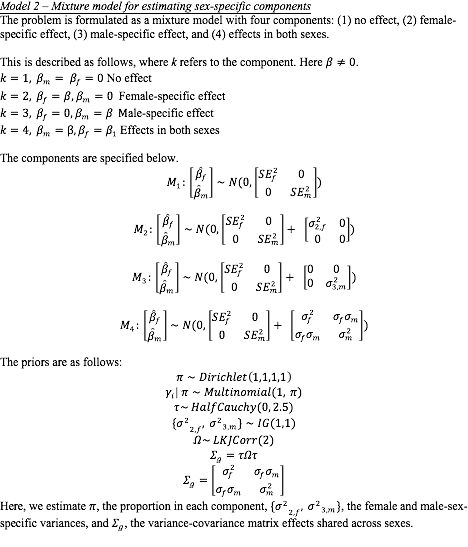

## SIMULATIONS

In [1]:
source("project_utils.R")
set.seed(607)

Loading required package: MASS
Loading required package: Matrix
Loading required package: mnormt


In [2]:

model2Simv2 <- function(N, p, sigmasq, S){
    # sigmasq is a vector of two variances
    # S is a variance-covariance matrix
    
    Sigma <- nearPD(S)$mat # nearest positive definite matrix
    zeros <- c(0,0)
    
    # sample squared SEs
    se2 <- simSE2(N)

    ### SAMPLE BETAS
    # M0
    n.m0 <- round(p[1]*N)
    se.m0 <- matrix(se2[1:(2*n.m0)], n.m0, 2)
    betas.m0 <- do.call(rbind, lapply(1:n.m0, function(x) mvrnorm(1, zeros, diag(se.m0[x,]))))

    # M1 
    n.m1 <- round(p[2]*N)
    se.m1 <- matrix(se2[(2*n.m0+1):(2*(n.m0+n.m1))], n.m1, 2)
    betas.m1 <- do.call(rbind, lapply(1:n.m1, function(x) 
        mvrnorm(1, zeros, diag(se.m1[x,])+diag(c(sigmasq[1], 0)))))

    # M2
    n.m2 <- round(p[3]*N)    
    se.m2 <- matrix(se2[(2*(n.m0+n.m1)+1):(2*(n.m0+n.m1+n.m2))], n.m2, 2)
    betas.m2 <- do.call(rbind, lapply(1:n.m2, function(x) 
        mvrnorm(1, zeros, diag(se.m2[x,])+diag(c(0,sigmasq[2])))))

    # M3
    n.m3 <- N-(n.m0+n.m1 + n.m2)
    se.m3 <- matrix(se2[(2*(n.m0+n.m1+n.m2)+1):(2*N)], n.m3, 2)
    betas.m3 <- do.call(rbind, lapply(1:n.m3, function(x) 
        mvrnorm(1, zeros, diag(se.m3[x,])+Sigma)))


    # put together
    betas <- do.call(rbind, list(betas.m0, betas.m1, betas.m2, betas.m3))
    ses <- do.call(rbind, list(se.m0, se.m1, se.m2, se.m3))
        
    cov.data.k4.sim <- list(
        N = N,
        M = 2,
        B = betas,
        SE = ses,
        K = 4
    )
    return(cov.data.k4.sim)
}                                                 


In [3]:
N <- 1000
p <- c(0.5, 0.05, 0.1, 0.25)
sigmasq <- c(0.02, 0.01)
S <- matrix(c(0.012,0.005, 0.005, 0.010),2,2)
cov.data.M2.sim <- model2Simv2(N, p, sigmasq, S)

In [4]:
# run stan to estimate the covariance
library(rstan)
options(warn=-1)
fit2_sim <- stan(
  file = "../models/model2_v2.stan",  # Stan program
  data = cov.data.M2.sim,    # named list of data
  chains = 4,             # number of Markov chains
  warmup = 200,          # number of warmup iterations per chain
  iter = 400,            # total number of iterations per chain
  cores = 2,              
  refresh = 1000          # show progress every 'refresh' iterations
  )


Loading required package: ggplot2
Loading required package: StanHeaders
rstan (Version 2.16.2, packaged: 2017-07-03 09:24:58 UTC, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())


In file included from /home/erflynn/R/x86_64-pc-linux-gnu-library/3.3/BH/include/boost/config.hpp:39:0,
                 from /home/erflynn/R/x86_64-pc-linux-gnu-library/3.3/BH/include/boost/math/tools/config.hpp:13,
                 from /home/erflynn/R/x86_64-pc-linux-gnu-library/3.3/StanHeaders/include/stan/math/rev/core/var.hpp:7,
                 from /home/erflynn/R/x86_64-pc-linux-gnu-library/3.3/StanHeaders/include/stan/math/rev/core/gevv_vvv_vari.hpp:5,
                 from /home/erflynn/R/x86_64-pc-linux-gnu-library/3.3/StanHeaders/include/stan/math/rev/core.hpp:12,
                 from /home/erflynn/R/x86_64-pc-linux-gnu-library/3.3/StanHeaders/include/stan/math/rev/mat.hpp:4,
                 from /home/erflynn/R/x86_64-pc-linux-gnu-library/3.3/StanHeaders/include/stan/math.hpp:4,
                 from /home/erflynn/R/x86_64-pc-linux-gnu-library/3.3/StanHeaders/include/src/stan/model/model_header.hpp:4,
                 from fileb6f74dcd3e72.cpp:8:
/home/erflynn/R/x86_64-

In [5]:
save(fit2_sim, cov.data.M2.sim, file="sim2.RData")

In [6]:
print(fit2_sim, pars=c("sigmasq", "Sigma", "pi", "lp__"), probs=c(0.1, 0.025, 0.975), digits_summary = 5)


Inference for Stan model: model2_v2.
4 chains, each with iter=400; warmup=200; thin=1; 
post-warmup draws per chain=200, total post-warmup draws=800.

                 mean se_mean       sd        10%       2.5%      97.5% n_eff
sigmasq[1]    0.85865 0.10238  2.22493    0.18060    0.12662    4.56756   472
sigmasq[2]    6.00192 2.10802 38.25005    0.30764    0.20914   23.30767   329
Sigma[1,1]    0.01158 0.00004  0.00094    0.01040    0.00977    0.01346   643
Sigma[1,2]    0.00423 0.00002  0.00059    0.00349    0.00310    0.00545   584
Sigma[2,1]    0.00423 0.00002  0.00059    0.00349    0.00310    0.00545   584
Sigma[2,2]    0.01110 0.00003  0.00075    0.01019    0.00975    0.01258   738
pi[1]         0.54842 0.00073  0.01799    0.52605    0.51225    0.58382   613
pi[2]         0.00584 0.00021  0.00510    0.00093    0.00025    0.01875   607
pi[3]         0.00171 0.00007  0.00195    0.00018    0.00006    0.00668   800
pi[4]         0.44402 0.00069  0.01771    0.42170    0.41105    0.479

If we try on a simulated sample where the true values for S vs. sigmasq differ a lot, we get much closer estimates of the proportion in each component and variances. 

In [7]:
N <- 1000
p <- c(0.5, 0.05, 0.1, 0.25)
sigmasq <- c(0.2, 0.1)
S <- matrix(c(0.012,0.005, 0.005, 0.010),2,2)
cov.data.M2.sim <- model2Simv2(N, p, sigmasq, S)

In [8]:
# run stan to estimate the covariance
library(rstan)
options(warn=-1)
fit2_sim <- stan(
  file = "../models/model2_v2.stan",  # Stan program
  data = cov.data.M2.sim,    # named list of data
  chains = 4,             # number of Markov chains
  warmup = 200,          # number of warmup iterations per chain
  iter = 400,            # total number of iterations per chain
  cores = 2,              
  refresh = 1000          # show progress every 'refresh' iterations
  )


In [9]:
save(fit2_sim, cov.data.M2.sim, file="sim2_2.RData")

In [10]:
print(fit2_sim, pars=c("sigmasq", "Sigma", "pi", "lp__"), probs=c(0.1, 0.025, 0.975), digits_summary = 5)


Inference for Stan model: model2_v2.
4 chains, each with iter=400; warmup=200; thin=1; 
post-warmup draws per chain=200, total post-warmup draws=800.

                 mean se_mean      sd        10%       2.5%      97.5% n_eff
sigmasq[1]    0.25081 0.00223 0.06304    0.18376    0.16190    0.40352   800
sigmasq[2]    0.09610 0.00056 0.01570    0.07713    0.07009    0.13507   800
Sigma[1,1]    0.01162 0.00004 0.00113    0.01020    0.00955    0.01394   800
Sigma[1,2]    0.00456 0.00003 0.00078    0.00359    0.00309    0.00615   800
Sigma[2,1]    0.00456 0.00003 0.00078    0.00359    0.00309    0.00615   800
Sigma[2,2]    0.01155 0.00004 0.00113    0.01012    0.00956    0.01403   800
pi[1]         0.49776 0.00067 0.01888    0.47189    0.46024    0.53325   800
pi[2]         0.05323 0.00033 0.00920    0.04177    0.03631    0.07237   800
pi[3]         0.11465 0.00053 0.01511    0.09547    0.08778    0.14617   800
pi[4]         0.33436 0.00073 0.02054    0.30844    0.29267    0.37346   800
lp

## M2 Results on real data

In [17]:
### -- chromosome 15 for trunk_fp -- ###
# We identify known sex-specific SNPs. 
# The estimate of the male sex-specific variance is high, with a large CI, but there are no male-specific SNPs.
load('../../data/m2_v3/f_m2_trunk_fp.RData')
f.spec.trunk15 <- read.table("../../data/m2_v3/f_spec_snp_tab_trunk_fp.txt", header=TRUE)
m.spec.trunk15 <- read.table("../../data/m2_v3/m_spec_snp_tab_trunk_fp.txt", header=TRUE)

print(fit2, pars=c("sigmasq", "Sigma", "pi", "lp__"), probs=c(0.1, 0.025, 0.975), digits_summary = 5)


Inference for Stan model: model2_v2.
4 chains, each with iter=600; warmup=200; thin=1; 
post-warmup draws per chain=400, total post-warmup draws=1600.

                   mean se_mean       sd          10%         2.5%        97.5%
sigmasq[1]      0.56288 0.02951  0.74906      0.18353      0.13064      2.11144
sigmasq[2]      7.60067 1.66098 60.31899      0.43282      0.28258     32.29296
Sigma[1,1]      0.00008 0.00000  0.00001      0.00007      0.00007      0.00010
Sigma[1,2]      0.00002 0.00000  0.00000      0.00002      0.00001      0.00002
Sigma[2,1]      0.00002 0.00000  0.00000      0.00002      0.00001      0.00002
Sigma[2,2]      0.00002 0.00000  0.00000      0.00002      0.00002      0.00002
pi[1]           0.76514 0.00068  0.02148      0.73748      0.72028      0.80514
pi[2]           0.00028 0.00000  0.00015      0.00010      0.00006      0.00064
pi[3]           0.00005 0.00000  0.00006      0.00001      0.00000      0.00021
pi[4]           0.23453 0.00068  0.02144      0.

In [19]:
nrow(f.spec.trunk15)
nrow(m.spec.trunk15) # none
f.spec.trunk15

[1] 4

[1] 0

SNP,CHR,BP,B_f,B_m,SE_f,SE_m,p_m,p_f,gene
rs16942341,15,89388905,-0.1097100,0.0125846,0.01077650,0.01040210,0.22635300,2.46732e-24,ACAN
rs35874463,15,67457698,0.0615468,0.0200622,0.00775777,0.00747630,0.00728773,2.14362e-15,SMAD3
rs3817428,15,89415247,-0.0540360,-0.0112301,0.00408460,0.00397892,0.00476737,6.26032e-40,ACAN
rs72770234,15,100660989,-0.0667568,-0.0131039,0.00742902,0.00723172,0.06998780,2.59333e-19,ADAMTS17


In [21]:
### -- all chromosomes for leg_fp -- ###
## This looks better in terms of the estimates of sex-specific variances than the partial one for trunk fp 
## I am running more traits now to see if this is consistent.
load('../../data/m2_v2/f_m2_leg_fp.RData')
f.spec.leg <- read.table("../../data/m2_v3/f_spec_snp_tab_leg_fp.txt", header=TRUE)
m.spec.leg <- read.table("../../data/m2_v3/m_spec_snp_tab_leg_fp.txt", header=TRUE)

print(fit2, pars=c("sigmasq", "Sigma", "pi", "lp__"), probs=c(0.1, 0.025, 0.975), digits_summary = 5)

Inference for Stan model: model2_v2.
4 chains, each with iter=600; warmup=200; thin=1; 
post-warmup draws per chain=400, total post-warmup draws=1600.

                   mean se_mean      sd          10%         2.5%        97.5%
sigmasq[1] 3.572000e-02 0.00025 0.00823 2.661000e-02 2.327000e-02 5.553000e-02
sigmasq[2] 1.133310e+00 0.11424 3.29385 2.410000e-01 1.695300e-01 4.287440e+00
Sigma[1,1] 5.000000e-05 0.00000 0.00000 4.000000e-05 4.000000e-05 5.000000e-05
Sigma[1,2] 1.000000e-05 0.00000 0.00000 1.000000e-05 1.000000e-05 1.000000e-05
Sigma[2,1] 1.000000e-05 0.00000 0.00000 1.000000e-05 1.000000e-05 1.000000e-05
Sigma[2,2] 2.000000e-05 0.00000 0.00000 2.000000e-05 2.000000e-05 2.000000e-05
pi[1]      7.260400e-01 0.00028 0.00772 7.158800e-01 7.107900e-01 7.402000e-01
pi[2]      2.400000e-04 0.00000 0.00004 1.900000e-04 1.600000e-04 3.300000e-04
pi[3]      1.000000e-05 0.00000 0.00001 0.000000e+00 0.000000e+00 3.000000e-05
pi[4]      2.737100e-01 0.00028 0.00771 2.636200e-01 2.595

In [23]:
m.spec.leg
f.spec.leg

SNP,CHR,BP,B_f,B_m,SE_f,SE_m,p_m,p_f,gene
rs507666,9,136149399,-0.0173947,-0.0465847,0.00469994,0.00462964,8.25130e-24,2.14782e-04,ABO
rs72702209,1,154848581,0.0545399,0.0803379,0.01206570,0.01191980,1.59118e-11,6.18173e-06,KCNN3


SNP,CHR,BP,B_f,B_m,SE_f,SE_m,p_m,p_f,gene
Affx-35293625,16,89986117,0.0409299,9.37974e-04,0.00589032,0.00585062,8.72629e-01,3.70214e-12,NA
rs11144688,9,78542286,0.0424127,9.69475e-03,0.00559059,0.00553198,7.96912e-02,3.30644e-14,PCSK5
rs112018183,15,88907630,0.0775193,-2.31691e-02,0.01669570,0.01662820,1.63512e-01,3.43543e-06,MRPL46
rs112594996,9,96914890,-0.0502847,3.15634e-03,0.00870149,0.00858952,7.13273e-01,7.53514e-09,PTPDC1
rs115254649,6,30152130,-0.0820249,7.19545e-03,0.01584400,0.01614460,6.55823e-01,2.25727e-07,TRIM15
rs115584674,1,150346106,0.0516200,1.38558e-02,0.00761956,0.00757495,6.73767e-02,1.25136e-11,RPRD2
rs11580946,1,150551327,-0.0892288,-1.08593e-02,0.01431730,0.01394740,4.36223e-01,4.61020e-10,MCL1
rs116320423,6,30067427,-0.0804078,6.96762e-03,0.01583050,0.01624320,6.67955e-01,3.79259e-07,TRIM31
rs117187575,20,33171268,-0.0646845,7.27433e-03,0.01046970,0.01044520,4.86162e-01,6.49661e-10,PIGU
rs11729800,4,73541684,-0.0584492,-8.99124e-03,0.00740436,0.00736709,2.22292e-01,2.94845e-15,ADAMTS3
